In [417]:
# create dependencies
import pandas as pd
import glob
import csv
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import os


In [418]:
# get directory where csv files are stored
csv_path = Path("./Resources/NOAA Storm Data")

# get a list of all csv files in the directory
csv_files = glob.glob(str(csv_path / '*.csv'))

# declare an empty dataframe to store csv data
storm_details_list = []

# specify which columns to read
columns_to_read = ['YEAR','MONTH_NAME', 'STATE', 'EVENT_TYPE', 'INJURIES_DIRECT', 'DEATHS_DIRECT', 'DAMAGE_PROPERTY']

# loop through each CSV file and read it into the dataframe
for csv_file in csv_files:
    df = pd.read_csv(csv_file, usecols=columns_to_read)
    storm_details_list.append(df)

# combine lists into one dataframe
storm_details_df = pd.concat(storm_details_list, ignore_index=True)

# columns to keep:  Hurricane (Typhoon), Flash Flood, Wildfire, 
storm_details_df_filtered = storm_details_df[storm_details_df['EVENT_TYPE'].isin(['Hurricane (Typhoon)', 'Tornado', 'Flood', 'Wildfire', 'Winter Storm'])]


In [419]:
# Function to convert DAMAGE_PROPERTY to integers
def convert_damage(value):
    if isinstance(value, str):
        # Remove commas
        value = value.replace(",", "")
        
        # Check for empty string after removing commas
        if value == "":  # If the string is empty after removing commas
            return 0
        
        # convert K, M, B suffixes for thousand, million, and billion into integers
        if value[-1] in ('K', 'M', 'B'):
            try:
                if value[-1] == 'K':
                    multiplier = 1_000
                elif value[-1] == 'M':
                    multiplier = 1_000_000
                elif value[-1] == 'B':
                    multiplier = 1_000_000_000

                # Convert the number part and apply the multiplier
                return int(float(value[:-1]) * multiplier)
            except ValueError:
                return 0  # Handle conversion errors
        else:
            try:
                # Convert directly if no K, M, or B suffix
                return int(value)
            except ValueError:
                return 0  # Handle conversion errors
    return 0  # Return 0 for NaN or unrecognized formats

storm_details_df_filtered['DAMAGE_PROPERTY'] = storm_details_df_filtered['DAMAGE_PROPERTY'].apply(convert_damage)

# Group by 'STATE' and 'MONTH_NAME', then aggregate the data
storm_summary = (
    storm_details_df_filtered.groupby(['STATE', 'EVENT_TYPE', 'YEAR'])
    .agg({
        'INJURIES_DIRECT': 'sum',       # Sum of direct injuries
        'DEATHS_DIRECT': 'sum',         # Sum of direct deaths
        'DAMAGE_PROPERTY': 'sum'        # Sum of property damage (assuming it's numeric)
    })
    .reset_index()  # Reset index for a cleaner DataFrame
)

storm_summary.to_csv('./Resources/storm_summary.csv')

C:\Users\thegr\AppData\Local\Temp\ipykernel_167364\3663455774.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  storm_details_df_filtered['DAMAGE_PROPERTY'] = storm_details_df_filtered['DAMAGE_PROPERTY'].apply(convert_damage)


In [420]:
# remove rows that have all zeroes
storm_summary = storm_summary[(storm_summary[['INJURIES_DIRECT', 'DEATHS_DIRECT', 'DAMAGE_PROPERTY']] != 0).any(axis=1)]

# display sample of data
storm_summary.head()

,STATE,EVENT_TYPE,YEAR,INJURIES_DIRECT,DEATHS_DIRECT,DAMAGE_PROPERTY
1,ALABAMA,Flood,2005,0,0,65000
3,ALABAMA,Flood,2008,0,0,5000
4,ALABAMA,Flood,2009,0,0,2687000
5,ALABAMA,Flood,2010,0,0,2018000
6,ALABAMA,Flood,2011,0,0,35000


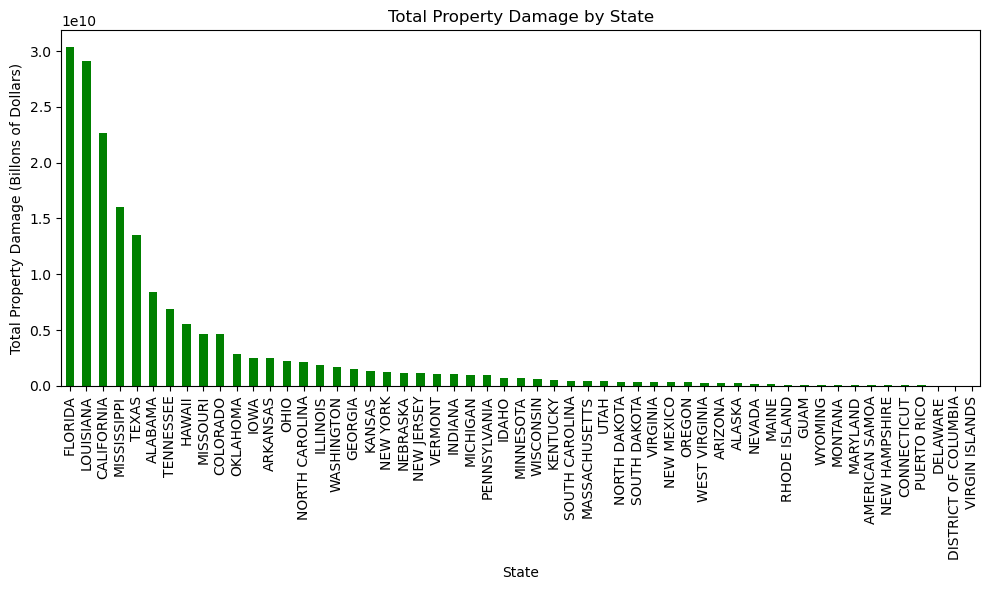

In [436]:
# create a bar chart to display this data of hurricane
# Filter data for a specific event type (e.g., 'Hurricane (Typhoon)')
#event_data = storm_summary[storm_summary['EVENT_TYPE'] == 'Hurricane (Typhoon)']

# Group by state and sum the property damage (or choose another metric if needed)
event_data_by_state = storm_summary.groupby('STATE')['DAMAGE_PROPERTY'].sum().sort_values(ascending=False)

# Plot bar chart directly with pandas
event_data_by_state.plot(kind='bar', figsize=(10, 6), color='green')
plt.xlabel('State')
plt.ylabel('Total Property Damage (Billons of Dollars)')
plt.title('Total Property Damage by State')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to fit labels


plt.savefig('./Plot Images/total_property_damage_by_state.png')

plt.show()

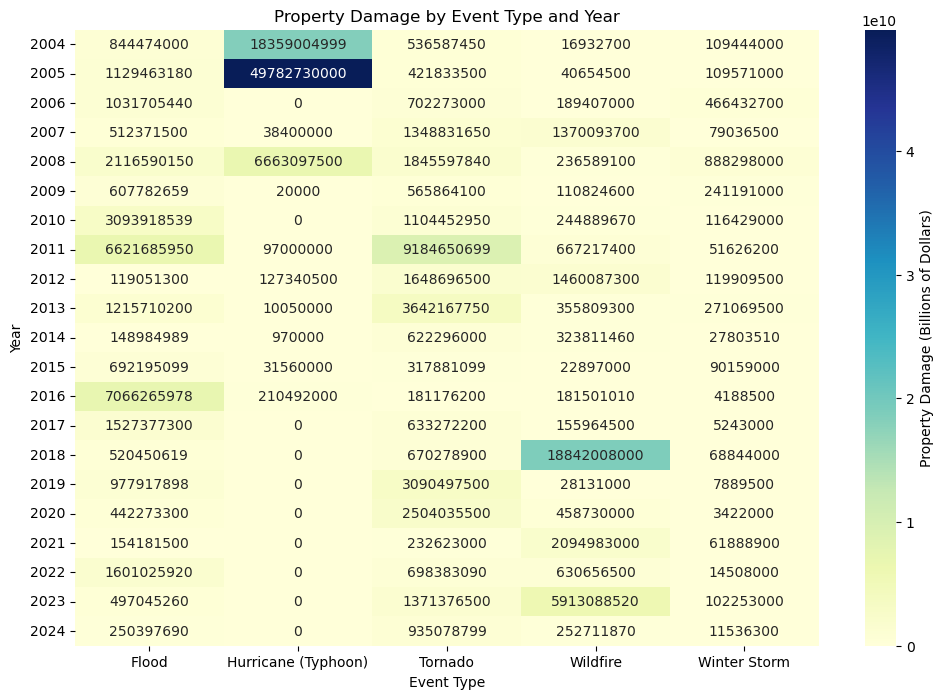

In [438]:
# Pivot data for heatmap
event_year_summary = storm_summary.pivot_table(index='YEAR', columns='EVENT_TYPE', values='DAMAGE_PROPERTY', aggfunc='sum').fillna(0)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(event_year_summary, cmap='YlGnBu', annot=True, fmt='.0f', cbar_kws={'label': 'Property Damage (Billions of Dollars)'})
plt.xlabel('Event Type')
plt.ylabel('Year')
plt.title('Property Damage by Event Type and Year')

plt.savefig('./Plot Images/property_damage_by_event_type_and_year.png')

plt.show()

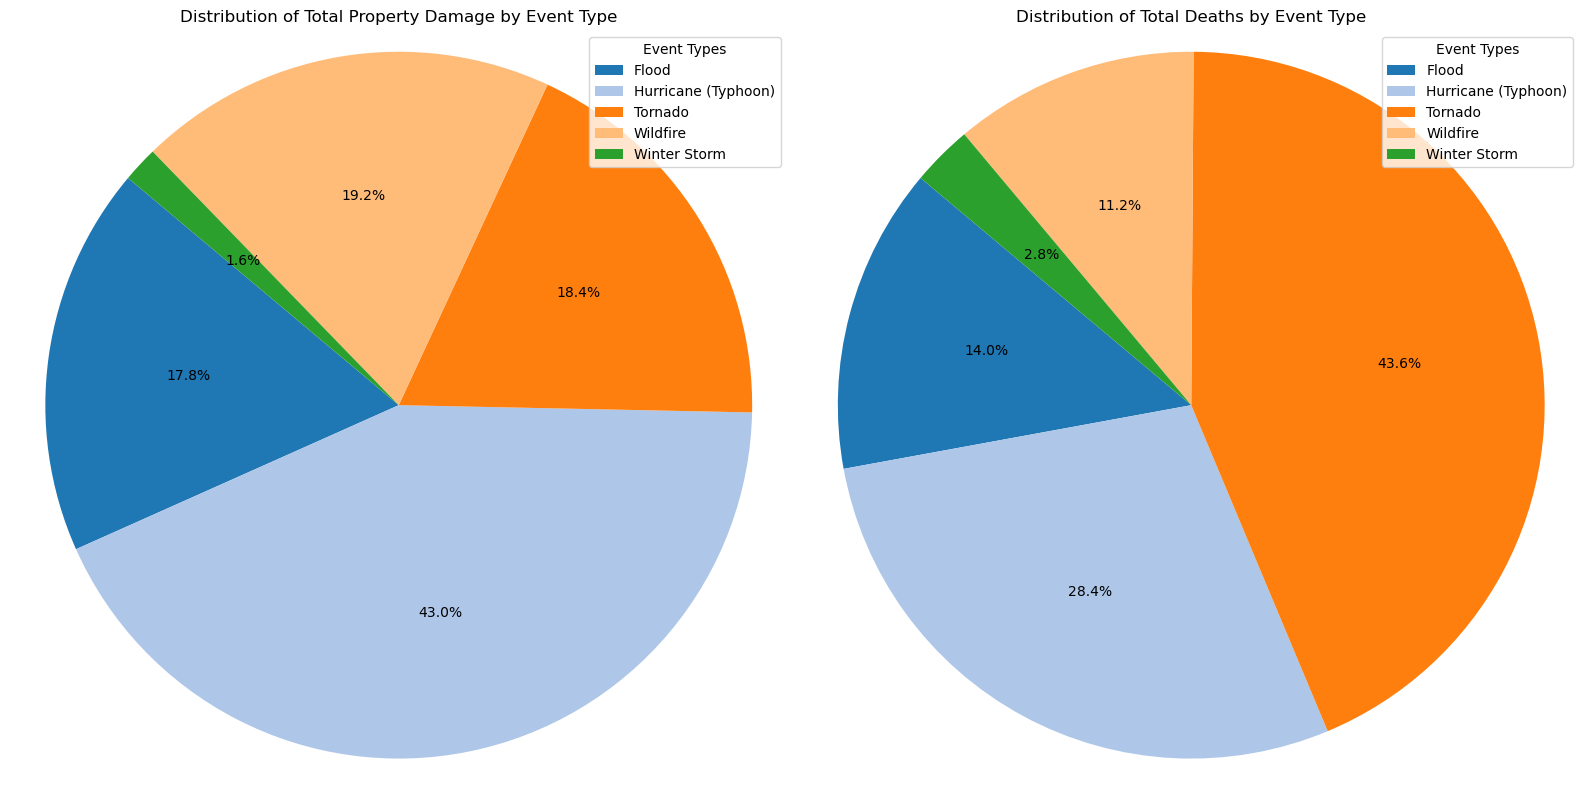

In [440]:
# create a pie chart to display this data
# Group data by event type and sum the property damage and deaths
event_damage = storm_summary.groupby('EVENT_TYPE')['DAMAGE_PROPERTY'].sum()
event_deaths = storm_summary.groupby('EVENT_TYPE')['DEATHS_DIRECT'].sum()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Plot the first pie chart for property damage
axs[0].pie(event_damage, autopct='%1.1f%%', startangle=140, colors=plt.get_cmap('tab20').colors)
axs[0].set_title('Distribution of Total Property Damage by Event Type')
axs[0].axis('equal')  # Equal aspect ratio ensures the pie chart is circular
axs[0].legend(event_damage.index, title="Event Types", loc="upper right")  # Add legend for property damage

# Plot the second pie chart for deaths
axs[1].pie(event_deaths, autopct='%1.1f%%', startangle=140, colors=plt.get_cmap('tab20').colors)
axs[1].set_title('Distribution of Total Deaths by Event Type')
axs[1].axis('equal')  # Equal aspect ratio ensures the pie chart is circular
axs[1].legend(event_deaths.index, title="Event Types", loc="upper right")  # Add legend for deaths

plt.savefig('./Plot Images/pie_chart_damage_by_event_type.png')

# plot
plt.tight_layout()  # Adjusts the layout to make room for titles
plt.show()

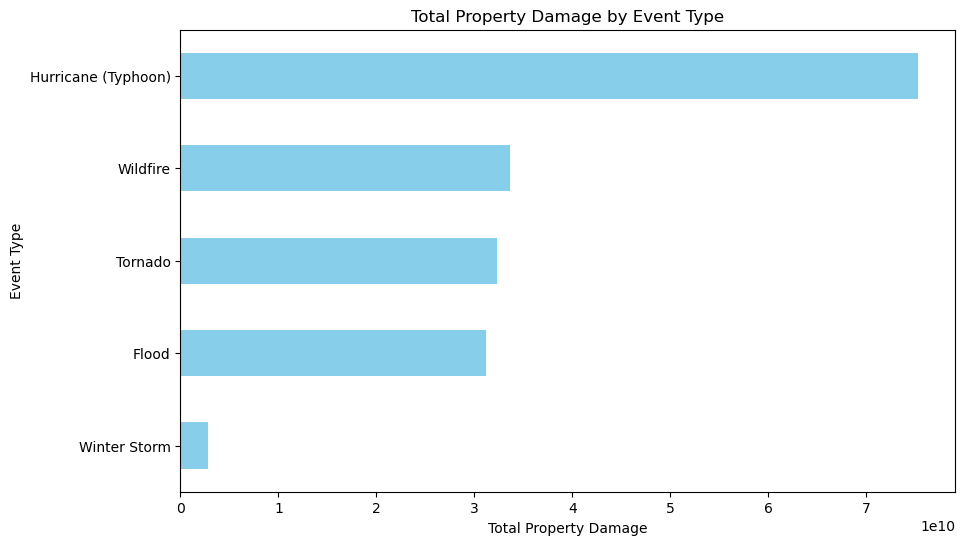

In [442]:
# Group by event type and sum damage and display per event type
event_summary = storm_summary.groupby('EVENT_TYPE')['DAMAGE_PROPERTY'].sum().sort_values()

# Plot bar chart
event_summary.plot(kind='barh', figsize=(10, 6), color='skyblue')
plt.xlabel('Total Property Damage')
plt.ylabel('Event Type')
plt.title('Total Property Damage by Event Type')

plt.savefig('./Plot Images/stacked_bar_chart_damage_by_event_type.png')

plt.show()

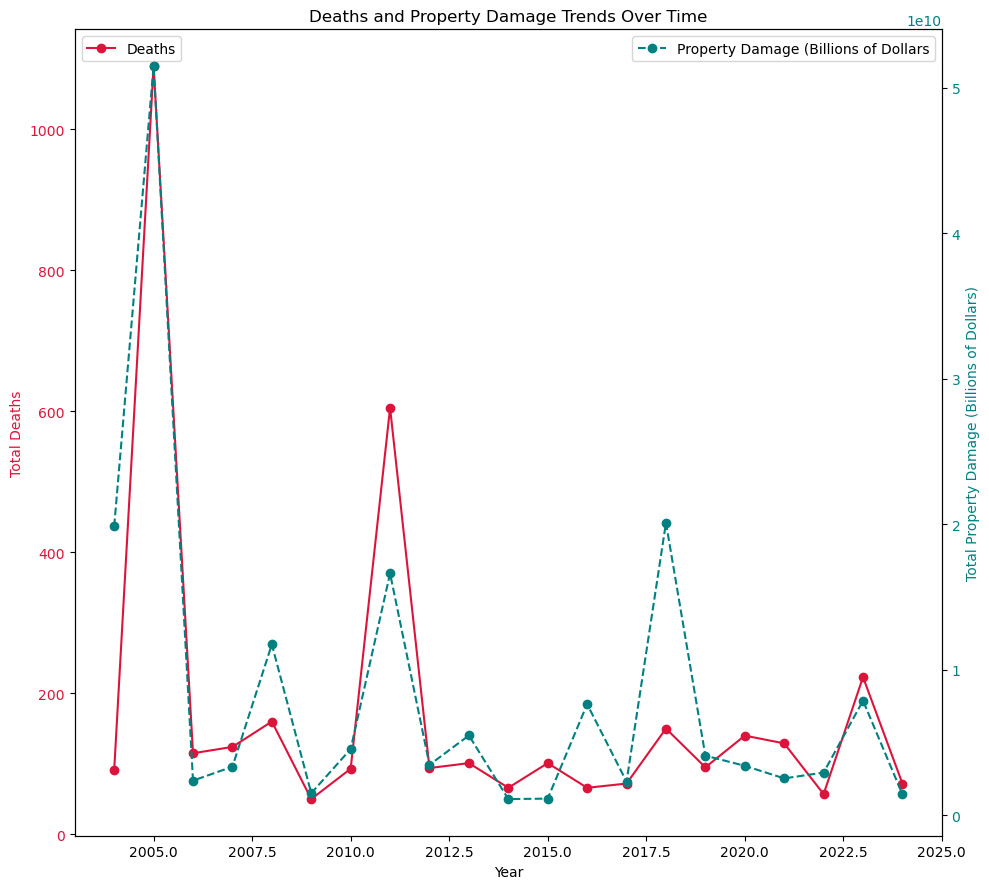

In [444]:
# Group data by year, summing deaths and property damage
deaths_and_damage = storm_summary.groupby('YEAR')[['DEATHS_DIRECT', 'DAMAGE_PROPERTY']].sum()

# Create a dual-axis line chart
fig, ax1 = plt.subplots(figsize=(10, 9))

# Plot deaths on the first y-axis
ax1.plot(deaths_and_damage.index, deaths_and_damage['DEATHS_DIRECT'], color='crimson', marker='o', label='Deaths')
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Deaths', color='crimson')
ax1.tick_params(axis='y', labelcolor='crimson')

# Create a second y-axis for property damage
ax2 = ax1.twinx()
ax2.plot(deaths_and_damage.index, deaths_and_damage['DAMAGE_PROPERTY'], color='teal', marker='o', linestyle='--', label='Property Damage (Billions of Dollars')
ax2.set_ylabel('Total Property Damage (Billions of Dollars)', color='teal')
ax2.tick_params(axis='y', labelcolor='teal')

# Add titles and grid for clarity
plt.title('Deaths and Property Damage Trends Over Time')
fig.tight_layout()  # Adjust layout to fit both y-axis labels

# Optional: Add a legend
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.savefig('./Plot Images/dual_line_chart_deaths_damage.png')

plt.show()

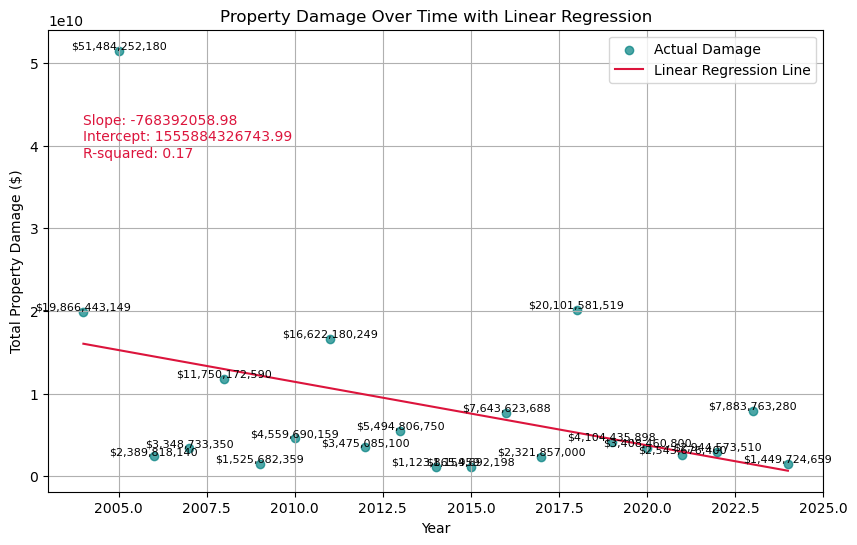

In [446]:
# Aggregate the data by year to get total property damage for each year
yearly_damage = storm_summary.groupby('YEAR')['DAMAGE_PROPERTY'].sum().reset_index()

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(yearly_damage['YEAR'], yearly_damage['DAMAGE_PROPERTY'])

# Generate fitted values
yearly_damage['Predicted_Damage'] = intercept + slope * yearly_damage['YEAR']

# Plot the scatter plot and regression line
plt.figure(figsize=(10, 6))
plt.scatter(yearly_damage['YEAR'], yearly_damage['DAMAGE_PROPERTY'], color='teal', alpha=0.7, label='Actual Damage')
plt.plot(yearly_damage['YEAR'], yearly_damage['Predicted_Damage'], color='crimson', label='Linear Regression Line')
plt.xlabel('Year')
plt.ylabel('Total Property Damage ($)')
plt.title('Property Damage Over Time with Linear Regression')
plt.legend()

# Optional: Display slope and intercept on the plot
plt.text(yearly_damage['YEAR'].min(), yearly_damage['DAMAGE_PROPERTY'].max() * 0.75, 
         f"Slope: {slope:.2f}\nIntercept: {intercept:.2f}\nR-squared: {r_value**2:.2f}",
         fontsize=10, color="crimson")

# Adding dollar amount values to each scatter point
for i in range(len(yearly_damage)):
    plt.text(yearly_damage['YEAR'][i], yearly_damage['DAMAGE_PROPERTY'][i],
             f"${yearly_damage['DAMAGE_PROPERTY'][i]:,.0f}", 
             fontsize=8, ha='center', va='bottom', color='black')

plt.grid(True)

plt.savefig('./Plot Images/scatter_plot_linear_reg_damage.png')

plt.show()

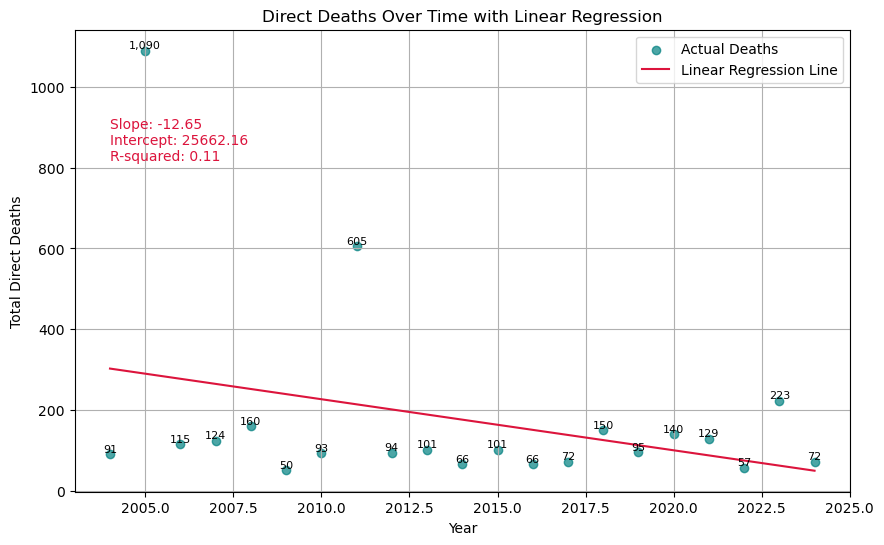

In [448]:
# Aggregate the data by year to get total direct deaths for each year
yearly_deaths = storm_summary.groupby('YEAR')['DEATHS_DIRECT'].sum().reset_index()

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(yearly_deaths['YEAR'], yearly_deaths['DEATHS_DIRECT'])

# Generate fitted values
yearly_deaths['Predicted_Deaths'] = intercept + slope * yearly_deaths['YEAR']

# Plot the scatter plot and regression line
plt.figure(figsize=(10, 6))
plt.scatter(yearly_deaths['YEAR'], yearly_deaths['DEATHS_DIRECT'], color='teal', alpha=0.7, label='Actual Deaths')
plt.plot(yearly_deaths['YEAR'], yearly_deaths['Predicted_Deaths'], color='crimson', label='Linear Regression Line')
plt.xlabel('Year')
plt.ylabel('Total Direct Deaths')
plt.title('Direct Deaths Over Time with Linear Regression')
plt.legend()

# Optional: Display slope and intercept on the plot
plt.text(yearly_deaths['YEAR'].min(), yearly_deaths['DEATHS_DIRECT'].max() * 0.75, 
         f"Slope: {slope:.2f}\nIntercept: {intercept:.2f}\nR-squared: {r_value**2:.2f}",
         fontsize=10, color="crimson")

# Adding dollar amount values to each scatter point
for i in range(len(yearly_damage)):
    plt.text(yearly_deaths['YEAR'][i], yearly_deaths['DEATHS_DIRECT'][i],
             f"{yearly_deaths['DEATHS_DIRECT'][i]:,.0f}", 
             fontsize=8, ha='center', va='bottom', color='black')

plt.savefig('./Plot Images/scatter_plot_linear_reg_deaths.png')

plt.grid(True)
plt.show()

In [426]:
# set path to read new csv with ocean temperature data so we can combine them
csv_path_2 = Path("./Resources/temperature_data_2014_2024.csv")

ocean_temp_data = pd.read_csv(csv_path_2)

# revise property damage and deaths dataframe to show only deaths and property damage per year
deaths_and_damage_df = storm_summary.groupby("YEAR").agg({
    "DEATHS_DIRECT": "sum",
    "DAMAGE_PROPERTY": "sum"
}).reset_index()

# convert date column to proper date format
ocean_temp_data['date'] = pd.to_datetime(ocean_temp_data['date'])

# convert date column to year only so I can group my year and take the average
ocean_temp_data['year'] = ocean_temp_data['date'].dt.year



# revise ocean temperature dataframe to show only total averages by year
ocean_temp_data_mean = ocean_temp_data.groupby("year")["temperature"].mean().reset_index()

# drop rows with years before 2014 to match ocean temp data
deaths_and_damage_df_filtered = deaths_and_damage_df[deaths_and_damage_df["YEAR"] >= 2014]

# rename the year column in the dataframe to match the two dataframe column names
deaths_and_damage_df_filtered = deaths_and_damage_df_filtered.rename(columns={"YEAR": "year"})

# combine the dataframes
combined_df = pd.merge(ocean_temp_data_mean, deaths_and_damage_df_filtered, on="year", how="inner")

#display the combined data
combined_df


,year,temperature,DEATHS_DIRECT,DAMAGE_PROPERTY
0,2014,20.5081,66,1123865959
1,2015,18.3562,101,1154692198
2,2016,19.7903,66,7643623688
3,2017,18.0789,72,2321857000
4,2018,19.9615,150,20101581519
5,2019,18.4645,95,4104435898
6,2020,18.9973,140,3408460800
7,2021,17.1167,129,2543676400
8,2022,17.8344,57,2944573510
9,2023,18.1788,223,7883763280


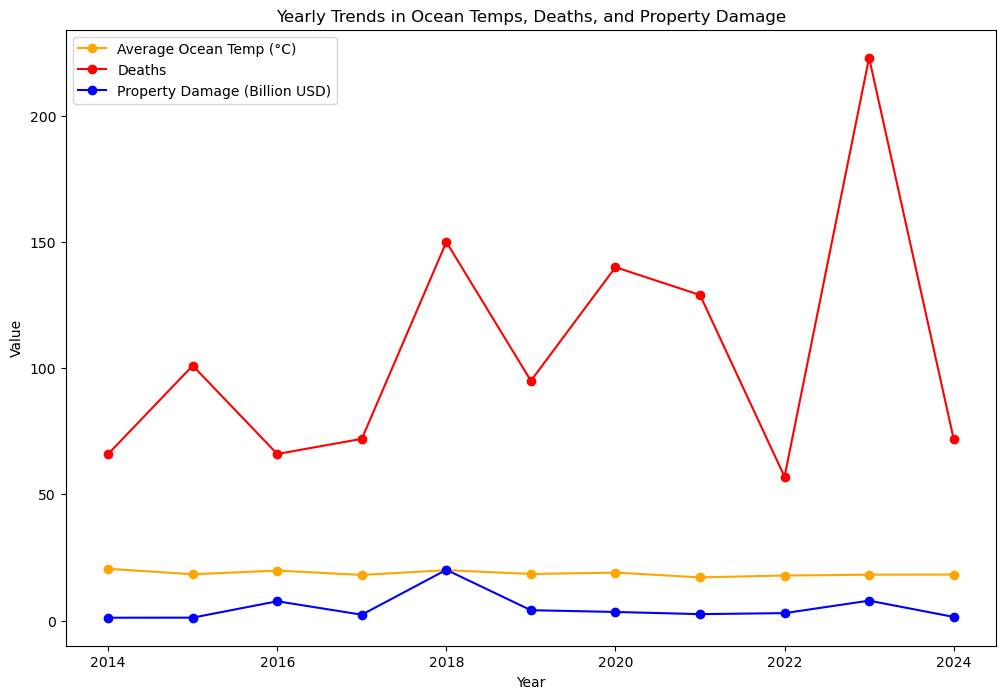

In [450]:
# create a line plot to display this correlation

# Set 'year' as the index for plotting
combined_df.set_index("year", inplace=True)

# Plotting
ax = combined_df["temperature"].plot(label="Average Ocean Temp (°C)", color="orange", marker="o", figsize=(12, 8))
combined_df["DEATHS_DIRECT"].plot(label="Deaths", color="red", marker="o", ax=ax)
(combined_df["DAMAGE_PROPERTY"] / 1e9).plot(label="Property Damage (Billion USD)", color="blue", marker="o", ax=ax)

# Labels and title
plt.xlabel("Year")
plt.ylabel("Value")
plt.title("Yearly Trends in Ocean Temps, Deaths, and Property Damage")
plt.legend()

# save plot in image file
plt.savefig('./Plot Images/line_plot_deaths_damage_ocean_temps.png')

# Show plot
plt.show()

In [428]:
# set path to read new csv with air temperatures
csv_path_3 = Path("./Resources/air_temps.csv")

# read the csv into a dataframe
air_temp_data = pd.read_csv(csv_path_3)

# convert date column to proper date format
air_temp_data['date'] = pd.to_datetime(air_temp_data['date'])

# convert date column to year only so I can group my year and take the average
air_temp_data['year'] = air_temp_data['date'].dt.year

# revise ocean temperature dataframe to show only total averages by year
air_temp_data_mean = air_temp_data.groupby("year")["temperature"].mean().reset_index()

# combine the dataframes
total_combined_df = pd.merge(air_temp_data_mean, combined_df, on="year", how="inner")

# rename columns for temperatures to differentiate them
total_combined_df = total_combined_df.rename(columns={'temperature_x': 'air_temps', 'temperature_y': 'ocean_temps'})

#display the combined data
total_combined_df

,year,air_temps,ocean_temps,DEATHS_DIRECT,DAMAGE_PROPERTY
0,2014,22.5685,20.5081,66,1123865959
1,2015,21.9093,18.3562,101,1154692198
2,2016,23.4701,19.7903,66,7643623688
3,2017,20.9610,18.0789,72,2321857000
4,2018,21.1160,19.9615,150,20101581519
5,2019,20.1123,18.4645,95,4104435898
6,2020,21.7216,18.9973,140,3408460800
7,2021,20.7468,17.1167,129,2543676400
8,2022,20.2354,17.8344,57,2944573510
9,2023,19.2189,18.1788,223,7883763280


Air Temps - Slope: -0.2547, Intercept: 535.49, R-squared: 0.5048
Ocean Temps - Slope: -0.1905, Intercept: 403.34, R-squared: 0.3817
Deaths - Slope: 5.4091, Intercept: -10814.50, R-squared: 0.1269
Property Damage - Slope: -0.0164, Intercept: 38.03, R-squared: 0.0001


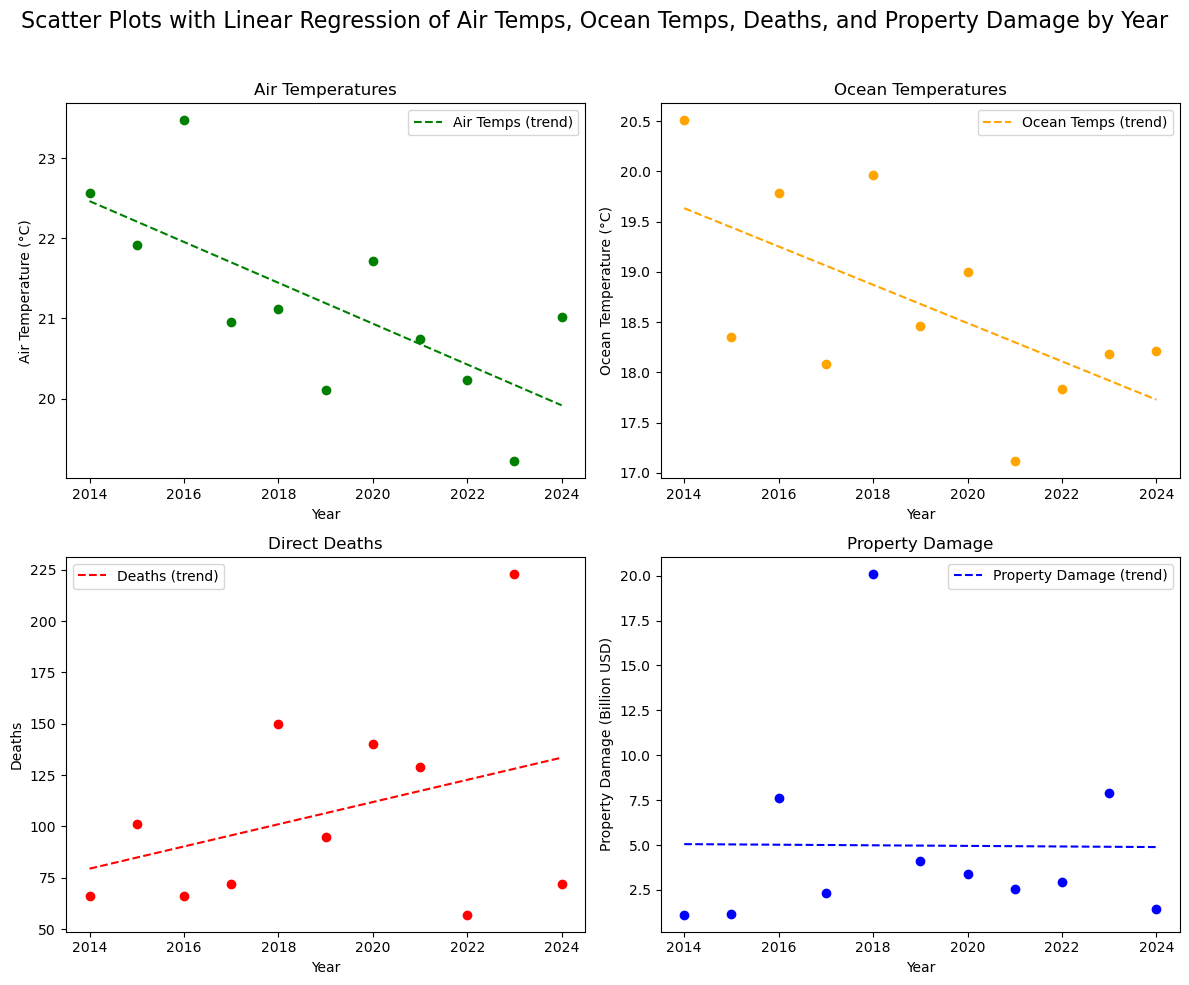

In [452]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Define function to add linear regression line and print slope and intercept
def add_regression(ax, x, y, color, label):
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    ax.plot(x, intercept + slope * x, color=color, linestyle="--", label=f"{label} (trend)")
    print(f"{label} - Slope: {slope:.4f}, Intercept: {intercept:.2f}, R-squared: {r_value**2:.4f}")
    return slope, intercept, r_value, p_value, std_err

# Set up the figure with a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Scatter Plots with Linear Regression of Air Temps, Ocean Temps, Deaths, and Property Damage by Year", fontsize=16)

# Scatter plot and regression for Air Temps
axs[0, 0].scatter(total_combined_df['year'], total_combined_df['air_temps'], color='green')
add_regression(axs[0, 0], total_combined_df['year'], total_combined_df['air_temps'], color='green', label="Air Temps")
axs[0, 0].set_title("Air Temperatures")
axs[0, 0].set_xlabel("Year")
axs[0, 0].set_ylabel("Air Temperature (°C)")

# Scatter plot and regression for Ocean Temps
axs[0, 1].scatter(total_combined_df['year'], total_combined_df['ocean_temps'], color='orange')
add_regression(axs[0, 1], total_combined_df['year'], total_combined_df['ocean_temps'], color='orange', label="Ocean Temps")
axs[0, 1].set_title("Ocean Temperatures")
axs[0, 1].set_xlabel("Year")
axs[0, 1].set_ylabel("Ocean Temperature (°C)")

# Scatter plot and regression for Deaths
axs[1, 0].scatter(total_combined_df['year'], total_combined_df['DEATHS_DIRECT'], color='red')
add_regression(axs[1, 0], total_combined_df['year'], total_combined_df['DEATHS_DIRECT'], color='red', label="Deaths")
axs[1, 0].set_title("Direct Deaths")
axs[1, 0].set_xlabel("Year")
axs[1, 0].set_ylabel("Deaths")

# Scatter plot and regression for Property Damage
axs[1, 1].scatter(total_combined_df['year'], total_combined_df['DAMAGE_PROPERTY'] / 1e9, color='blue')
add_regression(axs[1, 1], total_combined_df['year'], total_combined_df['DAMAGE_PROPERTY'] / 1e9, color='blue', label="Property Damage")
axs[1, 1].set_title("Property Damage")
axs[1, 1].set_xlabel("Year")
axs[1, 1].set_ylabel("Property Damage (Billion USD)")

# Add legends to each subplot
for ax in axs.flat:
    ax.legend()

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the main title

# Save the plot as an image file
plt.savefig("./Plot Images/scatter_plots_with_regression.png")

# Show plot
plt.show()

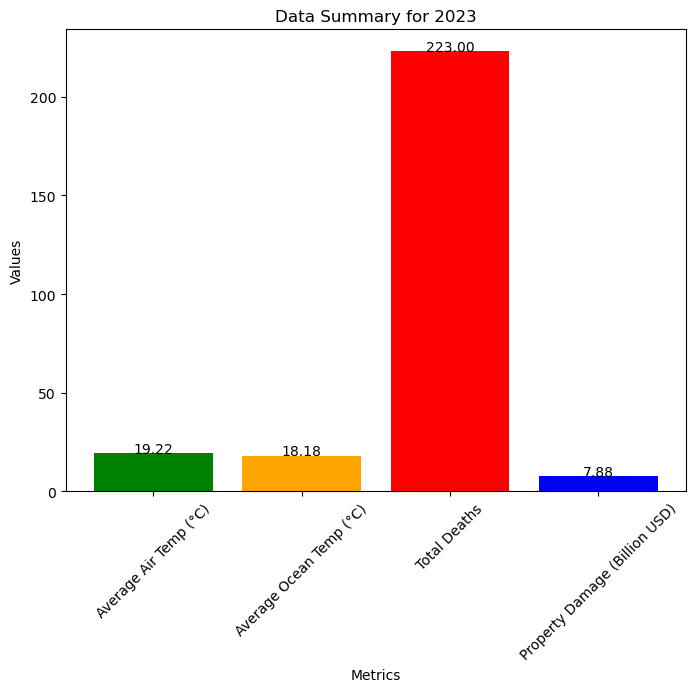

In [454]:
# Filter for 2023 data
data_2023 = total_combined_df[total_combined_df["year"] == 2023]

# Check if there's only one row for 2023
#print(data_2023)

# Plotting the data for 2023
plt.figure(figsize=(8, 6))
categories = ["Average Air Temp (°C)", "Average Ocean Temp (°C)", "Total Deaths", "Property Damage (Billion USD)"]
values = [data_2023["air_temps"].values[0], 
          data_2023["ocean_temps"].values[0], 
          data_2023["DEATHS_DIRECT"].values[0], 
          data_2023["DAMAGE_PROPERTY"].values[0] / 1e9]  # Convert to billions if needed

# Bar plot for clarity
plt.bar(categories, values, color=["green", "orange", "red", "blue"])
plt.title("Data Summary for 2023")
plt.ylabel("Values")
plt.xlabel("Metrics")
plt.xticks(rotation=45)

# Add value labels on top of bars
for i, v in enumerate(values):
    plt.text(i, v + 0.05, f"{v:.2f}", ha="center")

# Save the plot
plt.savefig("./Plot Images/data_summary_2023.png")

# Show plot
plt.show()

In [430]:
# set path to read new csv with air temperatures
csv_path_4 = Path("./Resources/disaster_data_cleaned.csv")

# read the csv into a dataframe
fema_data = pd.read_csv(csv_path_4)

# Convert declarationDate to datetime
fema_data['declarationDate'] = pd.to_datetime(fema_data['declarationDate'])

# Extract the year
fema_data['year'] = fema_data['declarationDate'].dt.year

# revise ocean temperature dataframe to show only total averages by year
fema_data_sum = fema_data.groupby("year")["obligatedTotalAmount"].sum().reset_index()

# combine the dataframes
final_combined_df = pd.merge(fema_data_sum, total_combined_df, on="year", how="inner")

#display the combined data
final_combined_df

,year,obligatedTotalAmount,air_temps,ocean_temps,DEATHS_DIRECT,DAMAGE_PROPERTY
0,2014,3.995729e+07,22.5685,20.5081,66,1123865959
1,2015,1.285663e+08,21.9093,18.3562,101,1154692198
2,2016,4.070331e+08,23.4701,19.7903,66,7643623688
3,2017,1.886465e+09,20.9610,18.0789,72,2321857000
4,2018,5.994532e+08,21.1160,19.9615,150,20101581519
5,2019,1.912344e+08,20.1123,18.4645,95,4104435898
6,2020,3.384029e+08,21.7216,18.9973,140,3408460800
7,2021,1.881187e+08,20.7468,17.1167,129,2543676400
8,2022,1.471846e+08,20.2354,17.8344,57,2944573510
9,2023,3.916383e+07,19.2189,18.1788,223,7883763280


Air Temps - Slope: -0.2547, Intercept: 535.49, R-squared: 0.5048
Ocean Temps - Slope: -0.1905, Intercept: 403.34, R-squared: 0.3817
Deaths - Slope: 5.4091, Intercept: -10814.50, R-squared: 0.1269
FEMA Obligated Amount - Slope: -0.0164, Intercept: 38.03, R-squared: 0.0001


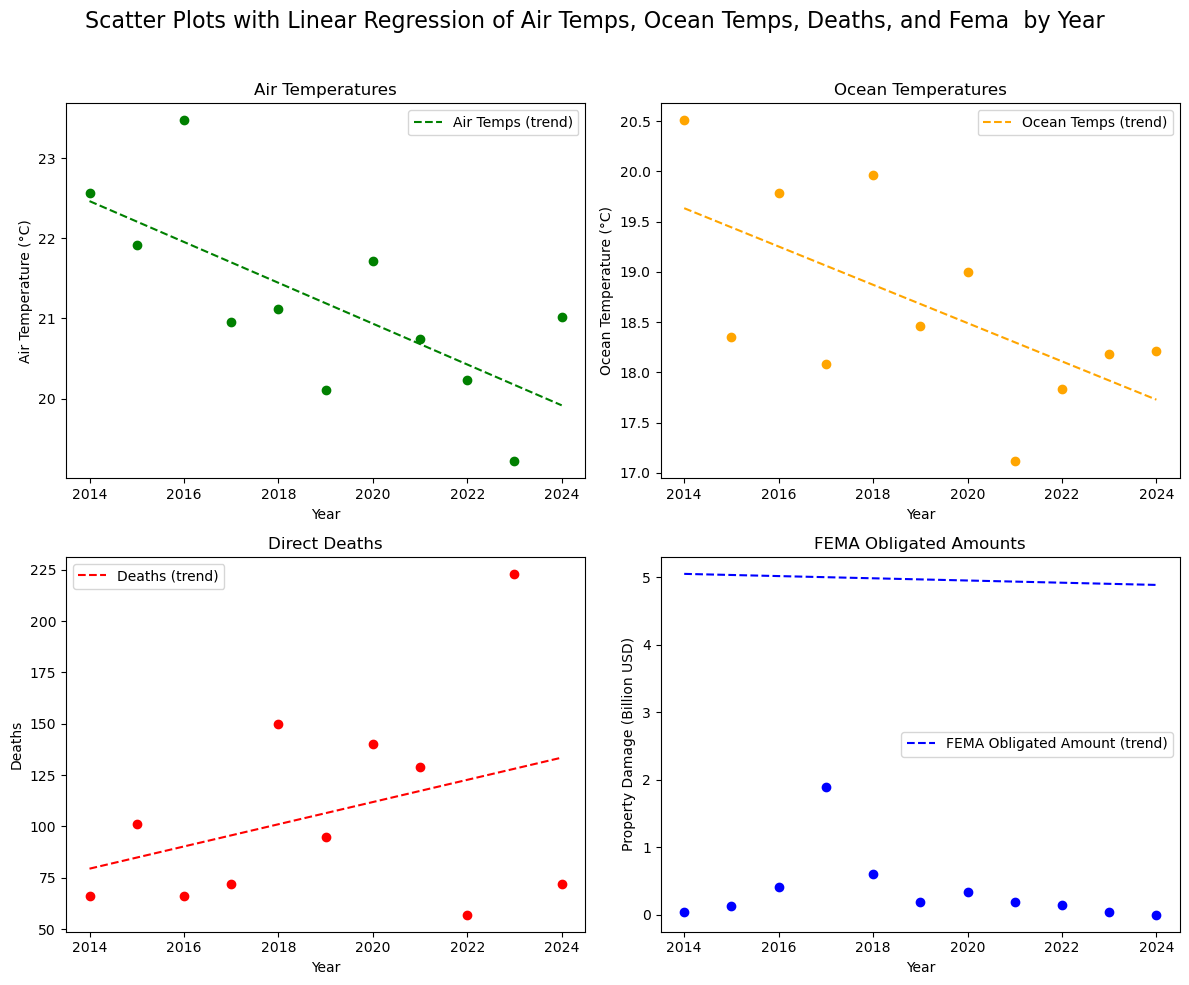

In [456]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Define function to add linear regression line and print slope and intercept
def add_regression(ax, x, y, color, label):
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    ax.plot(x, intercept + slope * x, color=color, linestyle="--", label=f"{label} (trend)")
    print(f"{label} - Slope: {slope:.4f}, Intercept: {intercept:.2f}, R-squared: {r_value**2:.4f}")
    return slope, intercept, r_value, p_value, std_err

# Set up the figure with a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Scatter Plots with Linear Regression of Air Temps, Ocean Temps, Deaths, and Fema  by Year", fontsize=16)

# Scatter plot and regression for Air Temps
axs[0, 0].scatter(final_combined_df['year'], final_combined_df['air_temps'], color='green')
add_regression(axs[0, 0], final_combined_df['year'], final_combined_df['air_temps'], color='green', label="Air Temps")
axs[0, 0].set_title("Air Temperatures")
axs[0, 0].set_xlabel("Year")
axs[0, 0].set_ylabel("Air Temperature (°C)")

# Scatter plot and regression for Ocean Temps
axs[0, 1].scatter(final_combined_df['year'], final_combined_df['ocean_temps'], color='orange')
add_regression(axs[0, 1], final_combined_df['year'], final_combined_df['ocean_temps'], color='orange', label="Ocean Temps")
axs[0, 1].set_title("Ocean Temperatures")
axs[0, 1].set_xlabel("Year")
axs[0, 1].set_ylabel("Ocean Temperature (°C)")

# Scatter plot and regression for Deaths
axs[1, 0].scatter(final_combined_df['year'], final_combined_df['DEATHS_DIRECT'], color='red')
add_regression(axs[1, 0], final_combined_df['year'], final_combined_df['DEATHS_DIRECT'], color='red', label="Deaths")
axs[1, 0].set_title("Direct Deaths")
axs[1, 0].set_xlabel("Year")
axs[1, 0].set_ylabel("Deaths")

# Scatter plot and regression for Property Damage
axs[1, 1].scatter(final_combined_df['year'], final_combined_df['obligatedTotalAmount'] / 1e9, color='blue')
add_regression(axs[1, 1], total_combined_df['year'], final_combined_df['DAMAGE_PROPERTY'] / 1e9, color='blue', label="FEMA Obligated Amount")
axs[1, 1].set_title("FEMA Obligated Amounts")
axs[1, 1].set_xlabel("Year")
axs[1, 1].set_ylabel("Property Damage (Billion USD)")

# Add legends to each subplot
for ax in axs.flat:
    ax.legend()

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the main title

# Save the plot as an image file
plt.savefig("./Plot Images/total_scatter_plots_with_regression.png")

# Show plot
plt.show()